# Parametric simulation using apmv setpoints

In [1]:
#todo import qgrid to manually change output dfs

In [2]:
import accim
from accim.parametric_and_optimisation.objectives import return_time_series
from accim.parametric_and_optimisation.utils import make_all_combinations
from besos import eppy_funcs as ef
import matplotlib.pyplot as plt
import seaborn as sns
from accim.utils import print_available_outputs_mod, get_accim_args
from accim.parametric_and_optimisation.main import OptimParamSimulation, get_rdd_file_as_df, get_mdd_file_as_df, parse_mtd_file
from os import listdir


Let's have a look at the files we currently have in the path:

In [4]:
from os import listdir
original_files = [i for i in listdir()]
original_files

['.ipynb_checkpoints',
 'param_sim_accim_custom_model.ipynb',
 'param_sim_accim_predefined_model.ipynb',
 'param_sim_apmv_setpoint.ipynb',
 'Seville.epw',
 'Sydney.epw',
 'TestModel.idf',
 'TestModel_aPMV.idf',
 '__init__.py']

Firstly, the IDF must be read using besos's `get_building` function.

In [5]:
building = ef.get_building('TestModel_aPMV.idf')

For this analysis, we want to use the HVAC system in all hours of the year, so that temperature is always comfortable. Therefore, we are going to set the occupancy to always on by means of the function `accim.utils.set_occupancy_to_always`, in which we input the IDF class instance we read in the previous cell.

In [6]:
accim.utils.set_occupancy_to_always(idf_object=building)

On 24/7 Schedule:Compact object was already in the model.
People PlantaX08:Office Number of People Schedule Name has been set to always occupied.


Now, let's start with the settings for the parametric analysis. First, let's instantiate the class `OptimParamSimulation`, and let's pass the IDF instance in the argument `building`. Argument `parameters_type` can take 3 different strings:
- "accim predefined model", in which models are those previously defined in accim (ComfStand=0 to ComfStand=22);
- "accim custom model", in which key parameters of the adaptive comfort model are defined in the relevant arguments;
- "apmv setpoints", in which setpoints are based on the aPMV (Adaptive Predicted Mean Vote) instead of the PMV index;

In this case, we're going to use the 'apmv setpoints' type, in which we can use setpoints based on the Adaptive Predicted Mean Vote (aPMV) index.

In [7]:
parametric = OptimParamSimulation(
    building=building,
    parameters_type='apmv setpoints',
    #output_type='standard', #
    #output_keep_existing=False, #
    #output_freqs=['hourly'], #
    #ScriptType='vrf_mm', #
    #SupplyAirTempInputMethod='temperature difference', #
    #debugging=True, #
    #verbosemode=False #
)

PMV_H_SP_PlantaX08_Office Schedule has been added
PMV_C_SP_PlantaX08_Office Schedule has been added
Added - PMV_PlantaX08_Office Sensor
Added - People_Occupant_Count_PlantaX08_Office Sensor
Added - PMV_H_SP_act_PlantaX08_Office Actuator
Added - PMV_C_SP_act_PlantaX08_Office Actuator
Added - CoolingSeason GlobalVariable object
Added - CoolSeasonEnd GlobalVariable object
Added - CoolSeasonStart GlobalVariable object
Added - tolerance_cooling_sp_PlantaX08_Office GlobalVariable object
Added - tolerance_cooling_sp_cooling_season_PlantaX08_Office GlobalVariable object
Added - tolerance_cooling_sp_heating_season_PlantaX08_Office GlobalVariable object
Added - tolerance_heating_sp_PlantaX08_Office GlobalVariable object
Added - tolerance_heating_sp_cooling_season_PlantaX08_Office GlobalVariable object
Added - tolerance_heating_sp_heating_season_PlantaX08_Office GlobalVariable object
Added - adap_coeff_PlantaX08_Office GlobalVariable object
Added - adap_coeff_heating_PlantaX08_Office GlobalVariab

An initial and generic version of the Adaptive-Comfort-Control-Implementation Script (ACCIS) has been added to the idf instance `building`. For instance, you can take a look at the parameter values accis currently has:

In [8]:
[i for i in building.idfobjects['energymanagementsystem:program'] if 'set_zone_input_data' in i.Name.lower()]

[
 ENERGYMANAGEMENTSYSTEM:PROGRAM,
     set_zone_input_data_PlantaX08_Office,    !- Name
     set adap_coeff_cooling_PlantaX08_Office = 0.293,    !- Program Line 1
     set adap_coeff_heating_PlantaX08_Office = -0.293,    !- Program Line 2
     set pmv_cooling_sp_PlantaX08_Office = -0.5,    !- Program Line 3
     set pmv_heating_sp_PlantaX08_Office = 0.5,    !- Program Line 4
     set tolerance_cooling_sp_cooling_season_PlantaX08_Office = -0.1,    !- Program Line 5
     set tolerance_cooling_sp_heating_season_PlantaX08_Office = -0.1,    !- Program Line 6
     set tolerance_heating_sp_cooling_season_PlantaX08_Office = 0.1,    !- Program Line 7
     set tolerance_heating_sp_heating_season_PlantaX08_Office = 0.1;    !- Program Line 8]

## Setting the outputs

**If you have already read any of the other parametric simulation examples, you can skip this entire outputs section, since it is exactly the same.**

### Outputs for the idf (i.e. the outputs for each simulation run)

First of all, we are going to set the outputs of the simulations that are going to be performed. This is an important step, especially if you are going to run hundreds or thousands of simulations.

Let's take a look at the Output:Variable objects we currently have in the idf. The method `get_output_var_df_from_idf()` returns a pandas DataFrame which contains the information of the existing Output:Variable objects in the idf:

In [9]:
df_output_variables_idf = parametric.get_output_var_df_from_idf()
df_output_variables_idf

key_value  \
0                         People PlantaX08:Office   
1                         People PlantaX08:Office   
2                         People PlantaX08:Office   
3                         People PlantaX08:Office   
4                                               *   
5                                               *   
6                                               *   
7                                               *   
8                                               *   
9                                               *   
10                                              *   
11                                              *   
12                                              *   
13                                              *   
14                                              *   
15                                              *   
16                                              *   
17                                              *   
18                                              *   
19                                              *   
20                                              *   
21                                              *   
22                                              *   
23                                              *   
24                                              *   
25                                              *   
26                                              *   
27                                              *   
28                                              *   
29                                              *   
30                                              *   
31                                              *   
32                                              *   
33                                              *   
34                                              *   
35                                              *   
36                                              *   
37                                              *   
38                                              *   
39                                              *   
40                                              *   
41                                              *   
42                                              *   
43                      PMV_H_SP_PlantaX08_Office   
44                      PMV_C_SP_PlantaX08_Office   
45  Default Air Velocity for Comfort Calculations   

                                        variable_name frequency schedule_name  
0               Zone Thermal Comfort Fanger Model PMV    hourly       On 24/7  
1               Zone Thermal Comfort Fanger Model PPD    hourly       On 24/7  
2       Zone Thermal Comfort Mean Radiant Temperature    hourly       On 24/7  
3          Zone Thermal Comfort Operative Temperature    hourly       On 24/7  
4                Site Outdoor Air Drybulb Temperature    hourly                
5               Site Outdoor Air Dewpoint Temperature    hourly                
6                                     Site Wind Speed    hourly                
7                                 Site Wind Direction    hourly                
8           Site Direct Solar Radiation Rate per Area    hourly                
9          Site Diffuse Solar Radiation Rate per Area    hourly                
10                           Site Solar Azimuth Angle    hourly                
11                          Site Solar Altitude Angle    hourly                
12               Site Outdoor Air Barometric Pressure    hourly                
13              Adaptive Coefficient_PlantaX08_Office    Hourly                
14                              aPMV_PlantaX08_Office    Hourly                
15             aPMV Heating Setpoint_PlantaX08_Office    Hourly                
16             aPMV Cooling Setpoint_PlantaX08_Office    Hourly                
17  aPMV Heating Setpoint No Tolerance_PlantaX08_O...    Hourly                
18  aPMV Cooling Setpoint No

now, let's see the Output:Meter objects:

In [10]:
df_output_meters_idf = parametric.get_output_meter_df_from_idf()
df_output_meters_idf.head()

Empty DataFrame
Columns: [key_name, frequency]
Index: []

In this case, we can see there is no Output:Meter. However, there is a large number of Output:Variable objects which might result in heavy simulation outputs. So, let's get rid of some of them. We can drop the rows we want, and then input the modified DataFrame in the method `set_output_var_df_to_idf(outputs_df)`.

In [11]:
df_output_variables_idf = df_output_variables_idf[
        df_output_variables_idf['variable_name'].str.contains('aPMV')
]
df_output_variables_idf

key_value                                      variable_name frequency  \
14         *                              aPMV_PlantaX08_Office    Hourly   
15         *             aPMV Heating Setpoint_PlantaX08_Office    Hourly   
16         *             aPMV Cooling Setpoint_PlantaX08_Office    Hourly   
17         *  aPMV Heating Setpoint No Tolerance_PlantaX08_O...    Hourly   
18         *  aPMV Cooling Setpoint No Tolerance_PlantaX08_O...    Hourly   

   schedule_name  
14                
15                
16                
17                
18

Let's keep only the Output:Variable objects we have filtered using the `set_output_var_df_to_idf(outputs_df)`:

In [12]:
parametric.set_output_var_df_to_idf(outputs_df=df_output_variables_idf)

We have removed all rows except the adaptive heating and cooling setpoints, the operative temperature and the running mean outdoor temperature. Next optional step is adding Output:Meter objects. We can do that using the method `set_output_met_objects_to_idf(output_meters)`, where `output_meters` is a list of Output:Meter key names.

In [13]:
output_meters = [
    'Heating:Electricity',
    'Cooling:Electricity',
    'Electricity:HVAC',
]
parametric.set_output_met_objects_to_idf(output_meters=output_meters)

Let's see Output:Meter objects we currently have after adding these:

In [14]:
df_output_meters_idf = parametric.get_output_meter_df_from_idf()
df_output_meters_idf

key_name frequency
0  Heating:Electricity    hourly
1  Cooling:Electricity    hourly
2     Electricity:HVAC    hourly

### Outputs to be read and shown in the parametric simulation or optimisation

To successfully run the parametric simulation or optimisation, it is advisable running a test simulation to know the outputs that each simulation will have. We can do that with the method `get_outputs_df_from_testsim()`, which returns a tuple containing 2 DataFrames containing respectively the Output:Meter and Output:Variable objects from the simulation. In this case, you won't find wildcards such as "*".

In [15]:
df_output_meters_testsim, df_output_variables_testsim = parametric.get_outputs_df_from_testsim()

In [16]:
df_output_meters_testsim

key_name frequency
0  Heating:Electricity    Hourly
1  Cooling:Electricity    Hourly
2     Electricity:HVAC    Hourly

In [17]:
df_output_variables_testsim

key_value                                      variable_name frequency
0       EMS                              aPMV_PlantaX08_Office    Hourly
1       EMS             aPMV Heating Setpoint_PlantaX08_Office    Hourly
2       EMS             aPMV Cooling Setpoint_PlantaX08_Office    Hourly
3       EMS  aPMV Heating Setpoint No Tolerance_PlantaX08_O...    Hourly
4       EMS  aPMV Cooling Setpoint No Tolerance_PlantaX08_O...    Hourly

We can get DataFrames from the .rdd and .mdd files generated from the test simulation using the functions `get_rdd_file_as_df()` and `get_mdd_file_as_df()`. 

In [18]:
df_rdd = get_rdd_file_as_df()
df_rdd

object key_value  \
0    Output:Variable         *   
1    Output:Variable         *   
2    Output:Variable         *   
3    Output:Variable         *   
4    Output:Variable         *   
..               ...       ...   
502  Output:Variable         *   
503  Output:Variable         *   
504  Output:Variable         *   
505  Output:Variable         *   
506  Output:Variable         *   

                                         variable_name frequency  \
0                 Site Outdoor Air Drybulb Temperature    hourly   
1                Site Outdoor Air Dewpoint Temperature    hourly   
2                 Site Outdoor Air Wetbulb Temperature    hourly   
3                      Site Outdoor Air Humidity Ratio    hourly   
4                   Site Outdoor Air Relative Humidity    hourly   
..                                                 ...       ...   
502  Zone Mechanical Ventilation Standard Density V...    hourly   
503  Zone Mechanical Ventilation Standard Density V...    hourly   
504  Zone Mechanical Ventilation Current Density Vo...    hourly   
505  Zone Mechanical Ventilation Current Density Vo...    hourly   
506   Zone Mechanical Ventilation Air Changes per Hour    hourly   

                                   units  
0                    !- Zone Average [C]  
1                    !- Zone Average [C]  
2                    !- Zone Average [C]  
3     !- Zone Average [kgWater/kgDryAir]  
4                    !- Zone Average [%]  
..                                   ...  
502               !- HVAC Average [m3/s]  
503                     !- HVAC Sum [m3]  
504               !- HVAC Average [m3/s]  
505                     !- HVAC Sum [m3]  
506                !- HVAC Average [ach]  

[507 rows x 5 columns]

In [19]:
df_mdd = get_mdd_file_as_df()
df_mdd

object                                   meter_name  \
0              Output:Meter                         Electricity:Facility   
1   Output:Meter:Cumulative                         Electricity:Facility   
2              Output:Meter                         Electricity:Building   
3   Output:Meter:Cumulative                         Electricity:Building   
4              Output:Meter            Electricity:Zone:PLANTAX08:OFFICE   
..                      ...                                          ...   
73  Output:Meter:Cumulative                  General:Heating:Electricity   
74             Output:Meter                   Carbon Equivalent:Facility   
75  Output:Meter:Cumulative                   Carbon Equivalent:Facility   
76             Output:Meter  CarbonEquivalentEmissions:Carbon Equivalent   
77  Output:Meter:Cumulative  CarbonEquivalentEmissions:Carbon Equivalent   

   frequency     units  
0     hourly    !- [J]  
1     hourly    !- [J]  
2     hourly    !- [J]  
3     hourly    !- [J]  
4     hourly    !- [J]  
..       ...       ...  
73    hourly    !- [J]  
74    hourly   !- [kg]  
75    hourly   !- [kg]  
76    hourly   !- [kg]  
77    hourly   !- [kg]  

[78 rows x 4 columns]

Also, we can parse the .mtd files as a list using the function `parse_mtd_file()`.

In [20]:
mtd_list = parse_mtd_file()
mtd_list[0:2]

[{'meter_id': '8',
  'description': 'PLANTAX08:OFFICE GENERAL LIGHTING:Lights Electricity Energy [J]',
  'on_meters': ['Electricity:Facility [J]',
   'Electricity:Building [J]',
   'Electricity:Zone:PLANTAX08:OFFICE [J]',
   'InteriorLights:Electricity [J]',
   'InteriorLights:Electricity:Zone:PLANTAX08:OFFICE [J]',
   'ELECTRIC EQUIPMENT#PlantaX08:Office#GeneralLights:InteriorLights:Electricity [J]']},
 {'meter_id': '92',
  'description': 'PLANTAX08:OFFICE:Zone Air System Sensible Heating Energy [J]',
  'on_meters': ['EnergyTransfer:Facility [J]',
   'EnergyTransfer:Building [J]',
   'EnergyTransfer:Zone:PLANTAX08:OFFICE [J]',
   'Heating:EnergyTransfer [J]',
   'Heating:EnergyTransfer:Zone:PLANTAX08:OFFICE [J]',
   'General:Heating:EnergyTransfer [J]']}]

Therefore, we have 2 DataFrames, one for the Output:Meter and another for the Output:Variable objects. Next step is setting the outputs for the parametric simulation. To do so, we'll need to pass the DataFrames into the method `set_outputs_for_simulation(df_output_meter, df_output_variable)`. If you have some knowledge about the python package besos, you might think of these dataframes as if each row was a `MeterReader` or `VariableReader` instances respectively for the Output:Meter and Output:Variable dataframes, and the arguments in these were the specified in the columns. The `MeterReader` class takes the arguments `key_name`, `frequency`, `name` and `func`, while `VariableReader` class takes the arguments  `key_value`, `variable_name`, `frequency`, `name` and `func`.

In [21]:
[i for i in df_output_meters_testsim.columns]

['key_name', 'frequency']

In [22]:
[i for i in df_output_variables_testsim.columns]

['key_value', 'variable_name', 'frequency']

If you take a look at the columns of the dataframes above, you can see the names are the arguments in the `MeterReader` and `VariableReader` classes, and only `name` and `func` are missing. That means, you can add these columns to input the `name` and `func` arguments as desired. In case of the Output:Meter dataframe, we won't add the `name` and `func` columns, which means the name will be the `key_name` and hourly results will be aggregated using the pd.Series.sum() function. However, in case of the Output:Variable dataframe, we will specify these: we want the hourly values rather than the aggregation, therefore we will pass the name bound to the function `return_time_series`, and we will add '_time series' as a suffix to the `variable_name` column. We will also remove the outputs for BLOCK1:ZONE2, which are the rows 2 and 4.

In [23]:
df_output_variables_testsim['func'] = return_time_series
df_output_variables_testsim['name'] = df_output_variables_testsim['variable_name'] + '_time series'
df_output_variables_testsim

key_value                                      variable_name frequency  \
0       EMS                              aPMV_PlantaX08_Office    Hourly   
1       EMS             aPMV Heating Setpoint_PlantaX08_Office    Hourly   
2       EMS             aPMV Cooling Setpoint_PlantaX08_Office    Hourly   
3       EMS  aPMV Heating Setpoint No Tolerance_PlantaX08_O...    Hourly   
4       EMS  aPMV Cooling Setpoint No Tolerance_PlantaX08_O...    Hourly   

                                                func  \
0  <function return_time_series at 0x00000124F3C4...   
1  <function return_time_series at 0x00000124F3C4...   
2  <function return_time_series at 0x00000124F3C4...   
3  <function return_time_series at 0x00000124F3C4...   
4  <function return_time_series at 0x00000124F3C4...   

                                                name  
0                  aPMV_PlantaX08_Office_time series  
1  aPMV Heating Setpoint_PlantaX08_Office_time se...  
2  aPMV Cooling Setpoint_PlantaX08_Office_time se...  
3  aPMV Heating Setpoint No Tolerance_PlantaX08_O...  
4  aPMV Cooling Setpoint No Tolerance_PlantaX08_O...

Finally, let's set the outputs for parametric simulation and optimisation:

In [24]:
parametric.set_outputs_for_simulation(
    df_output_meter=df_output_meters_testsim,
    df_output_variable=df_output_variables_testsim,
)

If you want to inspect the `VariableReader` and `MeterReader` objects, you can see the internal variable `sim_outputs`:

In [25]:
parametric.sim_outputs

[MeterReader(name='Heating:Electricity', class_name='Output:Meter', frequency='Hourly', func=<function sum_values at 0x000001248436ED30>, key_name='Heating:Electricity'),
 MeterReader(name='Cooling:Electricity', class_name='Output:Meter', frequency='Hourly', func=<function sum_values at 0x000001248436ED30>, key_name='Cooling:Electricity'),
 MeterReader(name='Electricity:HVAC', class_name='Output:Meter', frequency='Hourly', func=<function sum_values at 0x000001248436ED30>, key_name='Electricity:HVAC'),
 VariableReader(name='aPMV_PlantaX08_Office_time series', class_name='Output:Variable', frequency='Hourly', func=<function return_time_series at 0x00000124F3C438B0>, key_value='EMS', variable_name='aPMV_PlantaX08_Office'),
 VariableReader(name='aPMV Heating Setpoint_PlantaX08_Office_time series', class_name='Output:Variable', frequency='Hourly', func=<function return_time_series at 0x00000124F3C438B0>, key_value='EMS', variable_name='aPMV Heating Setpoint_PlantaX08_Office'),
 VariableRead

## Setting the parameters

At the top of the script, when you instantiated the class `OptimParamSimulation`, you already specified which type of parameters you were going to use. Now, the parameters we're about to set, must match the `parameters_type` argument. At this point, you may not know which parameters you can use, so you can call the method `get_available_parameters()`, which will return a list of available parameters:

In [26]:
available_parameters = parametric.get_available_parameters()
available_parameters

['Adaptive coefficient',
 'Adaptive cooling coefficient',
 'Adaptive heating coefficient',
 'PMV setpoint',
 'PMV cooling setpoint',
 'PMV heating setpoint']

If you don't know what are these, please refer to the [documentation](https://accim.readthedocs.io/en/master/4_detailed%20use.html).

The remaining parameters, which are:

In [27]:
#[i for i in available_parameters if '_AST' in i]

are used to set symmetrical comfort thresholds in case of 'CustAST_ASToffset' (i.e. a value of 3 means +3 is used as ACSToffset and -3 as AHSToffset), or in case of 'CustAST_ASTaul' and 'CustAST_ASTall', to set the same value to the applicability upper or lower limit for heating and cooling purposes (i.e. a value of 15 for CustAST_ASTall means 15 is used for CustAST_ACSTaul and CustAST_AHSTaul)

Using the 'apmv setpoints' type, the values can be either a list of options or a range of values. Now, let's set the parameters using the method `set_parameters(accis_params_dict, additional_params)`. In this method, we set the parameters related to accim using the argument `accis_params_dict`, which takes a dictionary following the pattern {'parameter name': [1, 2, 3, etc]} in case of list of options, or {'parameter name': (min_value, max_value)} in case of the range of values. We can also add some other parameters not related to accim in the argument `additional_params`, which takes a list of parameters as if these were input straight to the besos EPProblem class.

### Example 1

An example using ranges, could be:

In [28]:
accis_parameters = {
    'Adaptive coefficient': (0.01, 0.99),
    'PMV setpoint': (0.2, 0.7),
}
parametric.set_parameters(accis_params_dict=accis_parameters)

C:\Users\usuario\AppData\Local\Programs\Python\Python39\lib\site-packages\besos\parameters.py:441: UserWarning: This parameter's descriptor is already named Adaptive coefficient.The name used as an input (Adaptive coefficient) will be discarded.
  warnings.warn(
C:\Users\usuario\AppData\Local\Programs\Python\Python39\lib\site-packages\besos\parameters.py:441: UserWarning: This parameter's descriptor is already named PMV setpoint.The name used as an input (PMV setpoint) will be discarded.
  warnings.warn(


In this case, all parameters have been defined. Otherwise, we would be requested to continue with default values or to input them. Let's see Example 2.

A different option might be using m, n and ASToffset as parameters, and setting ASTall and ASTaul to some specific value so that these don't vary.

## Example 2

Now, let's use a list of options instead of range of values.

In [29]:
accis_parameters = {
    'Adaptive coefficient': [0, 0.3, 0.6],
    'PMV setpoint': [0.2, 0.5, 0.7],
}
parametric.set_parameters(accis_params_dict=accis_parameters)

Again, let's take a look at the arguments:

In [30]:
args = get_accim_args(building)
args

{'set_zone_input_data_PlantaX08_Office': {'adap_coeff_cooling_PlantaX08_Office': 0.293,
  'adap_coeff_heating_PlantaX08_Office': -0.293,
  'pmv_cooling_sp_PlantaX08_Office': -0.5,
  'pmv_heating_sp_PlantaX08_Office': 0.5,
  'tolerance_cooling_sp_cooling_season_PlantaX08_Office': -0.1,
  'tolerance_cooling_sp_heating_season_PlantaX08_Office': -0.1,
  'tolerance_heating_sp_cooling_season_PlantaX08_Office': 0.1,
  'tolerance_heating_sp_heating_season_PlantaX08_Office': 0.1}}

So, let's continue with Example 1.

In [31]:
accis_parameters = {
    'Adaptive coefficient': (0.01, 0.99),
    'PMV setpoint': (0.2, 0.7),
}
parametric.set_parameters(accis_params_dict=accis_parameters)

If you want to inspect the `Parameter` objects, you can see the internal variable `parameters_list`:

In [32]:
parametric.parameters_list

[Parameter(selector=GenericSelector(set=<function change_adaptive_coeff_all_zones at 0x0000012498551AF0>), value_descriptors=[RangeParameter(name='Adaptive coefficient', min=0.01, max=0.99)]),
 Parameter(selector=GenericSelector(set=<function change_pmv_setpoint_all_zones at 0x0000012498551CA0>), value_descriptors=[RangeParameter(name='PMV setpoint', min=0.2, max=0.7)])]

## Running the parametric simulation

### Setting the problem

First, let's set the problem. To do so, use the `set_problem()` method. In case of the parametric simulation you don't need to input any argument. However, in case of the optimisation, you must input the arguments `minimize_outputs`, `constraints` and `constraint_bounds`, similarly as you would do in the besos `EPProblem` class.

In [33]:
parametric.set_problem()

Again, you can inspect the `EPProblem` class instance in the internal variable `problem`:

In [34]:
parametric.problem

EPProblem(inputs=[Parameter(selector=GenericSelector(set=<function change_adaptive_coeff_all_zones at 0x0000012498551AF0>), value_descriptors=[RangeParameter(name='Adaptive coefficient', min=0.01, max=0.99)]), Parameter(selector=GenericSelector(set=<function change_pmv_setpoint_all_zones at 0x0000012498551CA0>), value_descriptors=[RangeParameter(name='PMV setpoint', min=0.2, max=0.7)])], outputs=[MeterReader(name='Heating:Electricity', class_name='Output:Meter', frequency='Hourly', func=<function sum_values at 0x000001248436ED30>, key_name='Heating:Electricity'), MeterReader(name='Cooling:Electricity', class_name='Output:Meter', frequency='Hourly', func=<function sum_values at 0x000001248436ED30>, key_name='Cooling:Electricity'), MeterReader(name='Electricity:HVAC', class_name='Output:Meter', frequency='Hourly', func=<function sum_values at 0x000001248436ED30>, key_name='Electricity:HVAC'), VariableReader(name='aPMV_PlantaX08_Office_time series', class_name='Output:Variable', frequency

### Sampling the simulation runs

The way to inform besos of the variations and permutations it must carry out in the parametric analysis is by means of a DataFrame, which must contain a column per `Parameter`, in which values are specified. There are multiple ways to do this DataFrame. For instance, we could make a dataframe from scratch:

In [35]:
import pandas as pd
param_dict = {
    'Adaptive coefficient': [0.1, 0.6], 
    'PMV setpoint': [0.2, 0.5], 
}
input_param_df = pd.DataFrame(data=param_dict)
input_param_df

Adaptive coefficient  PMV setpoint
0                   0.1           0.2
1                   0.6           0.5

We could input that df, which would result in 2 simulations. But now, imagine we want to make all possible combinations from the values we just did from scratch. We could use the function `make_all_combinations(parameters_values_dict)`. The argument `parameters_values_dict` must be a dictionary in the format {'parameter name': list_of_values}, such as the previouly defined param_dict, so let's input it. Let's see the possibilities:

In [36]:
all_combinations = make_all_combinations(param_dict)
all_combinations

Adaptive coefficient  PMV setpoint
0                   0.1           0.2
1                   0.1           0.5
2                   0.6           0.2
3                   0.6           0.5

Also, we can use the sampling functions from besos (`full_factorial` and `lhs`), which have been wrapped in the methods `sampling_full_factorial(level)` and `sampling_lhs(num_samples)`. After calling these, the samples are saved in the internal variable `parameters_values_df`. Let's see some examples:

In [37]:
parametric.sampling_lhs(num_samples=3)
parametric.parameters_values_df

Adaptive coefficient  PMV setpoint
0              0.161046      0.647970
1              0.582909      0.520494
2              0.955981      0.326564

In [38]:
parametric.sampling_full_factorial(level=3)
parametric.parameters_values_df

Adaptive coefficient  PMV setpoint
0              0.010000      0.200000
1              0.336667      0.200000
2              0.663333      0.200000
3              0.010000      0.366667
4              0.336667      0.366667
5              0.663333      0.366667
6              0.010000      0.533333
7              0.336667      0.533333
8              0.663333      0.533333

### Running the simulations

Now, we're ready to run the simulations, by means of the `run_parametric_simulation(epws, out_dir, df, processes)` method. After calling the method, the outputs (a DataFrame) is saved in the internal variable `outputs_param_simulation`. It is based on the use of the `EvaluatorEP` class, `df_apply` method. We want to run the parametric simulations with both Sydney and Seville climate files, therefore the filenames are input in a list in the `epws` argument. The simulation outputs will be saved in a directory named 'notebook_temp_dir'. The values for the parameters will be driven by the internal variable `parameters_values_df`, as input in the `df` argument.

In [39]:
parametric.run_parametric_simulation(
    epws=['Sydney.epw', 'Seville.epw'],
    out_dir='notebook_temp_dir',
    df=parametric.parameters_values_df,
    processes=4, # The number of CPUs to be used. Default is 2.
    #keep_input=True, # To keep the input values of parameters, as entered in df argument. Default is True.
    #keep_dirs=True # To keep the simulation outputs. Default is True.
)

Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...


Let's take a look at the simulation results

In [40]:
parametric.outputs_param_simulation

index  Adaptive coefficient  PMV setpoint  Heating:Electricity  \
0       0              0.010000      0.200000         4.430677e+09   
1       1              0.336667      0.200000         4.370369e+09   
2       2              0.663333      0.200000         4.287080e+09   
3       3              0.010000      0.366667         2.715173e+09   
4       4              0.336667      0.366667         2.520139e+09   
5       5              0.663333      0.366667         2.227634e+09   
6       6              0.010000      0.533333         1.587544e+09   
7       7              0.336667      0.533333         1.228050e+09   
8       8              0.663333      0.533333         7.316810e+08   
9       0              0.010000      0.200000         4.741650e+09   
10      1              0.336667      0.200000         4.645853e+09   
11      2              0.663333      0.200000         4.515799e+09   
12      3              0.010000      0.366667         2.390033e+09   
13      4              0.336667      0.366667         2.097282e+09   
14      5              0.663333      0.366667         1.690646e+09   
15      6              0.010000      0.533333         1.057647e+09   
16      7              0.336667      0.533333         6.537313e+08   
17      8              0.663333      0.533333         2.541049e+08   

    Cooling:Electricity  Electricity:HVAC  \
0          5.550654e+10      6.935760e+10   
1          5.582303e+10      6.966568e+10   
2          5.607719e+10      6.988272e+10   
3          4.983063e+10      6.129406e+10   
4          5.078110e+10      6.219936e+10   
5          5.147311e+10      6.272198e+10   
6          4.492337e+10      5.465422e+10   
7          4.678994e+10      5.643830e+10   
8          4.812971e+10      5.749629e+10   
9          5.255372e+10      6.641519e+10   
10         5.285230e+10      6.666769e+10   
11         5.309786e+10      6.682744e+10   
12         4.704551e+10      5.791326e+10   
13         4.797199e+10      5.869043e+10   
14         4.867181e+10      5.910165e+10   
15         4.276359e+10      5.172158e+10   
16         4.453935e+10      5.335833e+10   
17         4.589314e+10      5.451760e+10   

                    aPMV_PlantaX08_Office_time series  \
0   [0.09933135225694305, 0.09747402937981481, 0.0...   
1   [0.08472669118656813, 0.0829682145727887, 0.08...   
2   [0.07272163356571212, 0.07103183093021859, 0.0...   
3   [0.26432893872445135, 0.26258393049827494, 0.2...   
4   [0.20997146814517528, 0.20846649404045434, 0.2...   
5   [0.17246387757010237, 0.17084874526575433, 0.1...   
6   [0.428429222855546, 0.4265779302257047, 0.4271...   
7   [0.3146473378260366, 0.3131558664030421, 0.313...   
8   [0.24585721696018256, 0.24454105886194522, 0.2...   
9   [-0.0684066305595897, -0.09542065518525461, -0...   
10  [-0.08645892992548915, -0.1136028916586078, -0...   
11  [-0.10866911054647004, -0.13706998935755238, -...   
12  [-0.08334896562446882, -0.11908692518931617, -...   
13  [-0.11687259913436766, -0.14438398018081408, -...   
14  [-0.14947901357486224, -0.17033481375312265, -...   
15  [0.028246043602938014, -0.019138296944444546, ...   
16  [-0.03392245303705151, -0.06866027421932207, -...   
17  [-0.0872243174288312, -0.11433380526746546, -0...   

   aPMV Heating Setpoint_PlantaX08_Office_time series  \
0   [-0.10040080160320641, -0.10040080160320641, -...   
1   [-0.11443888491779843, -0.11443888491779843, -...   
2   [-0.13059185242121443, -0.13059185242121443, -...   
3   [-0.26801605888256935, -0.26801605888256935, -...   
4   [-0.31830396754975276, -0.31830396754975276, -...   
5   [-0.38451035090295105, -0.38451035090295105, -...   
6   [-0.4361930294906165, -0.4361930294906165, -0....   
7   [-0.5500541711809316, -0.5500541711809316, -0....   
8   [-0.725309491059147, -0.725309491059147, -0.72...   
9   [-0.10040080160320641, -0.10040080160320641, -...   
10  [-0.11443888491779843, -0.11443888491779843, -...   
11  [-0.13059185242121443, -0.13059185242121443, 

We can see the columns are the following:

- the parameters, which are:

In [41]:
[i.value_descriptors[0].name for i in parametric.parameters_list]

['Adaptive coefficient', 'PMV setpoint']

- the outputs, which are:

In [42]:
[i.name for i in parametric.sim_outputs]

['Heating:Electricity',
 'Cooling:Electricity',
 'Electricity:HVAC',
 'aPMV_PlantaX08_Office_time series',
 'aPMV Heating Setpoint_PlantaX08_Office_time series',
 'aPMV Cooling Setpoint_PlantaX08_Office_time series',
 'aPMV Heating Setpoint No Tolerance_PlantaX08_Office_time series',
 'aPMV Cooling Setpoint No Tolerance_PlantaX08_Office_time series']

- the path to the output files for each simulation, in the column 'out_dir'
- the epw for each simulation, in the column 'epw'

Let's round the values for the parameters columns:

In [43]:
for col in [i.value_descriptors[0].name for i in parametric.parameters_list]:
    parametric.outputs_param_simulation = parametric.outputs_param_simulation.round({col: 2})

### Visualising the results

#### Aggregated columns

At this point, if you have some knowledge of pandas and some package to plot the data (e.g. matplotlib or seaborn), you can carry out your own analysis and visualization. We're going to do some example below.

<Axes: xlabel='Heating:Electricity', ylabel='Cooling:Electricity'>

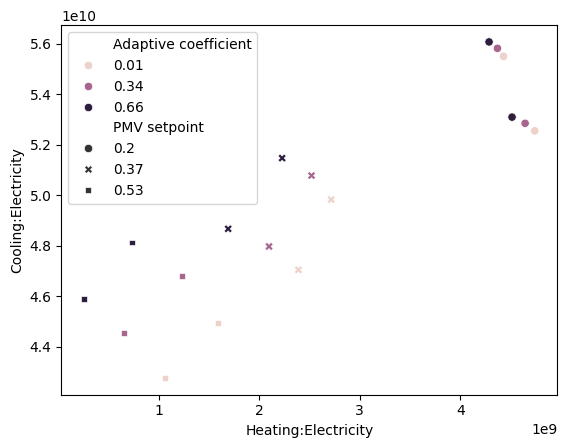

In [44]:
sns.scatterplot(
    data=parametric.outputs_param_simulation,
    x='Heating:Electricity',
    y='Cooling:Electricity',
    hue='Adaptive coefficient',
    style='PMV setpoint'
)

#### Time series columns

If you requested some output to be reported in time series, you can get a dataframe containing the hourly values using the method `get_hourly_df()`. This dataframe is saved in the internal variable `outputs_param_simulation_hourly`:

In [45]:
parametric.get_hourly_df()
parametric.outputs_param_simulation_hourly

Adaptive coefficient  PMV setpoint      epw  hour            datetime  \
0                       0.01          0.20   Sydney     1 2024-01-01 01:00:00   
1                       0.01          0.20   Sydney     2 2024-01-01 02:00:00   
2                       0.01          0.20   Sydney     3 2024-01-01 03:00:00   
3                       0.01          0.20   Sydney     4 2024-01-01 04:00:00   
4                       0.01          0.20   Sydney     5 2024-01-01 05:00:00   
...                      ...           ...      ...   ...                 ...   
157675                  0.66          0.53  Seville  8756 2024-12-30 20:00:00   
157676                  0.66          0.53  Seville  8757 2024-12-30 21:00:00   
157677                  0.66          0.53  Seville  8758 2024-12-30 22:00:00   
157678                  0.66          0.53  Seville  8759 2024-12-30 23:00:00   
157679                  0.66          0.53  Seville  8760 2024-12-31 00:00:00   

        aPMV_PlantaX08_Office_time series  \
0                                0.099331   
1                                0.097474   
2                                0.097966   
3                                0.098786   
4                                0.099169   
...                                   ...   
157675                          -0.296712   
157676                          -0.523263   
157677                          -0.718538   
157678                          -0.886391   
157679                          -0.972892   

        aPMV Heating Setpoint_PlantaX08_Office_time series  \
0                                               -0.100401    
1                                               -0.100401    
2                                               -0.100401    
3                                               -0.100401    
4                                               -0.100401    
...                                                   ...    
157675                                          -0.725309    
157676                                          -0.725309    
157677                                          -0.725309    
157678                                          -0.725309    
157679                                          -0.725309    

        aPMV Cooling Setpoint_PlantaX08_Office_time series  \
0                                                0.099601    
1                                                0.099601    
2                                                0.099601    
3                                                0.099601    
4                                                0.099601    
...                                                   ...    
157675                                           0.293959    
157676                                           0.293959    
157677                                           0.293959    
157678                                           0.293959    
157679                                           0.293959    

        aPMV Heating Setpoint No Tolerance_PlantaX08_Office_time series  \
0                                               -0.200401                 
1                                               -0.200401                 
2                                               -0.200401                 
3                                               -0.200401                 
4                                               -0.200401                 
...                                                   ...                 
157675                                          -0.825309                 
157676                                          -0.825309                 
157677                                          -0.825309                 
157678                                          -0.825309                 
157679                                          -0.825309                 

        aPMV Cooling Setpoint No Tolerance_PlantaX08_Office_time series  
0                            

Let's prepare the `outputs_param_simulation_hourly` df for plotting:

In [46]:
#Let's make a copy of the dataframe to not to modify the original one
df = parametric.outputs_param_simulation_hourly.copy()

#Let's remove the columns where value is the same for all rows
for c in df.columns:
    if len(set(df[c])) == 1:
        df = df.drop(columns=[c])
#Now let's remove the hour and datetime columns, since will
df = df.drop(columns=['hour'])

# Now let's reshape the df for plotting purposes
df = df.melt(id_vars=['datetime', 'Adaptive coefficient', 'PMV setpoint','epw'])


Now, we're going to plot time on x-axis, to see the variarion of the aPMV values throughout the year:

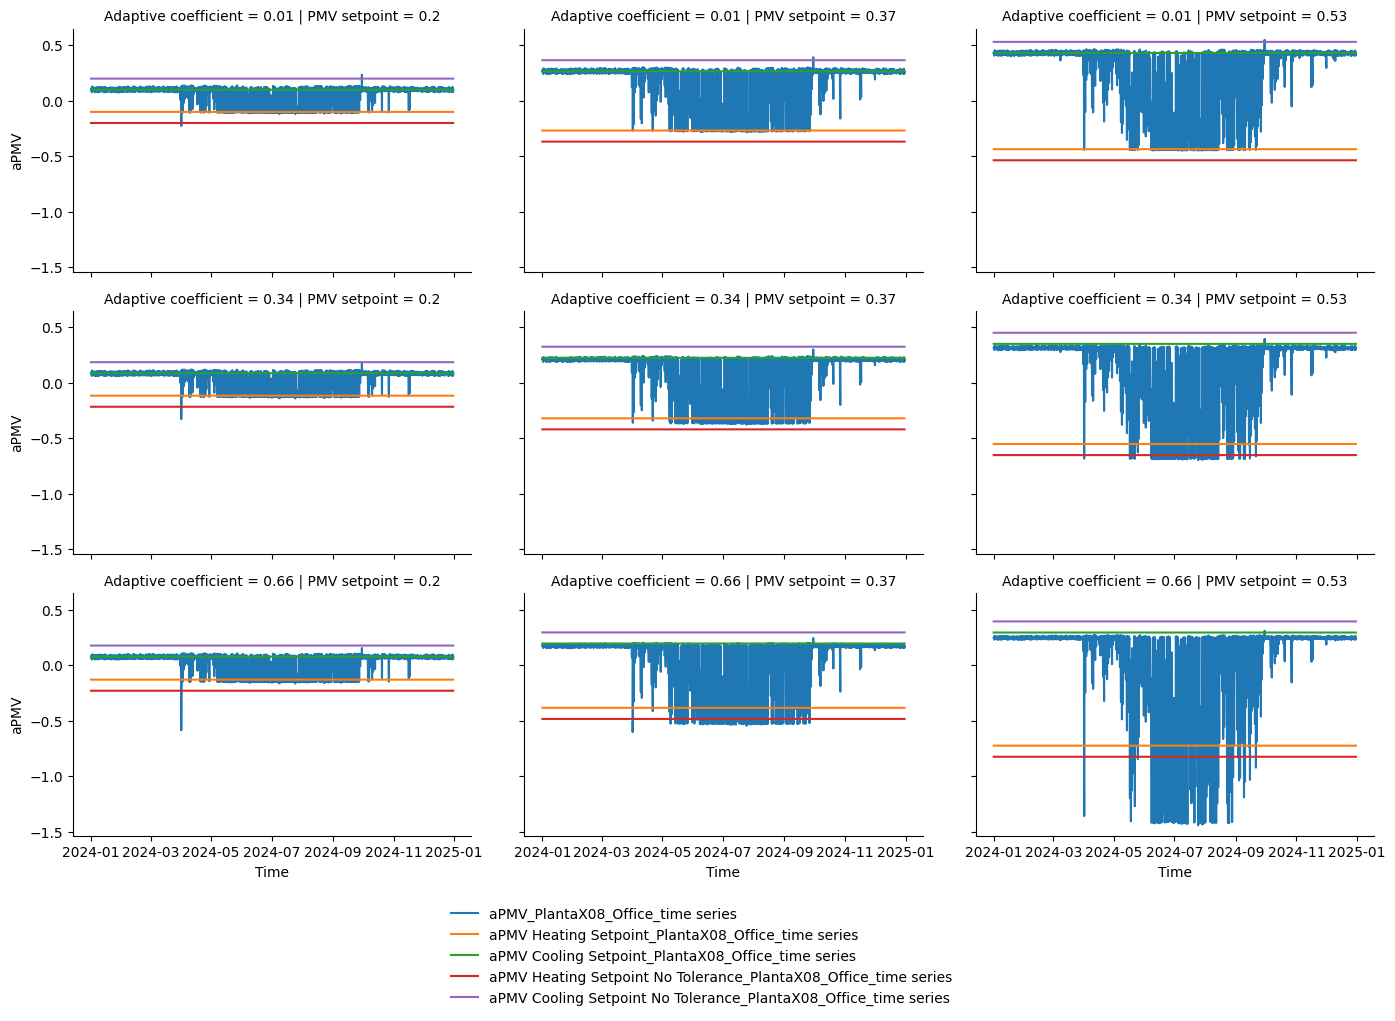

In [47]:
g = sns.FacetGrid(
    data=df[df['epw'].str.contains('Sydney')],
    row='Adaptive coefficient',
    col='PMV setpoint'
)
g.map_dataframe(
    sns.lineplot,
    x='datetime',
    y='value',
    hue='variable',
)
g.set_axis_labels('Time', 'aPMV')
g.add_legend(loc='upper center', bbox_to_anchor=(0.5, 0))
plt.tight_layout()


We could also do the same for Seville

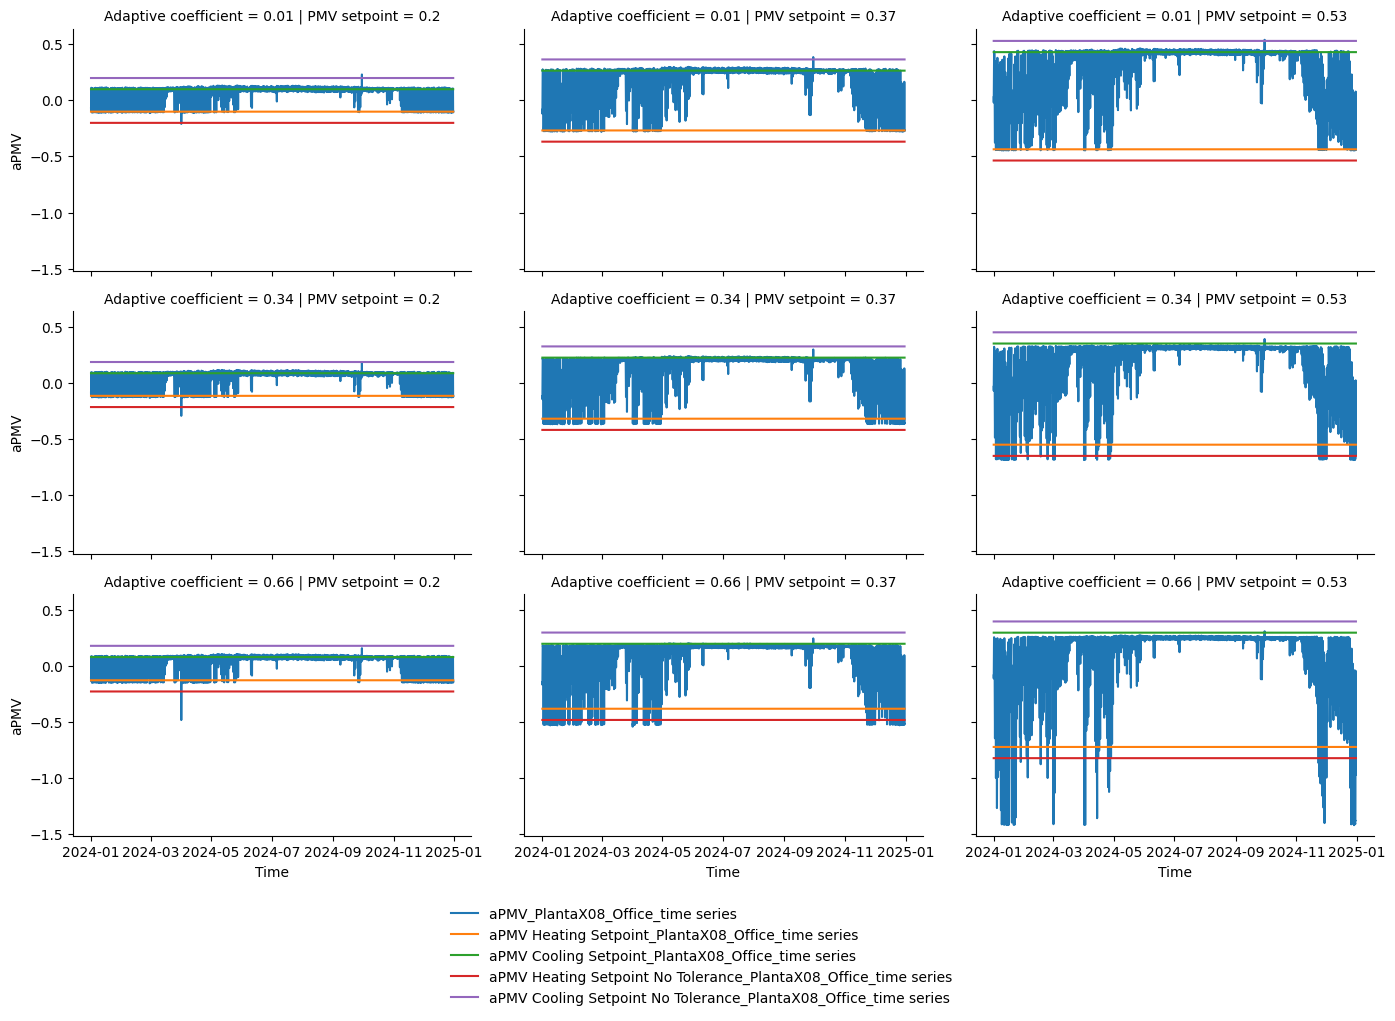

In [48]:
g = sns.FacetGrid(
    data=df[df['epw'].str.contains('Seville')],
    row='Adaptive coefficient',
    col='PMV setpoint'
)
g.map_dataframe(
    sns.lineplot,
    x='datetime',
    y='value',
    hue='variable',
)
g.set_axis_labels('Time', 'aPMV')
g.add_legend(loc='upper center', bbox_to_anchor=(0.5, 0))
plt.tight_layout()

We're done with the example, so let's remove all new files, so that we can re-run it again.

In [49]:
current_files = [i for i in listdir()]
new_files = set(current_files) - set(original_files)
new_files

{'available_outputs', 'notebook_temp_dir'}

In [50]:
import os
import shutil
for item in new_files:
    item_path = os.path.join(os.getcwd(), item)
    if os.path.isfile(item_path):
        os.remove(item_path)
    elif os.path.isdir(item_path):
        shutil.rmtree(item_path)